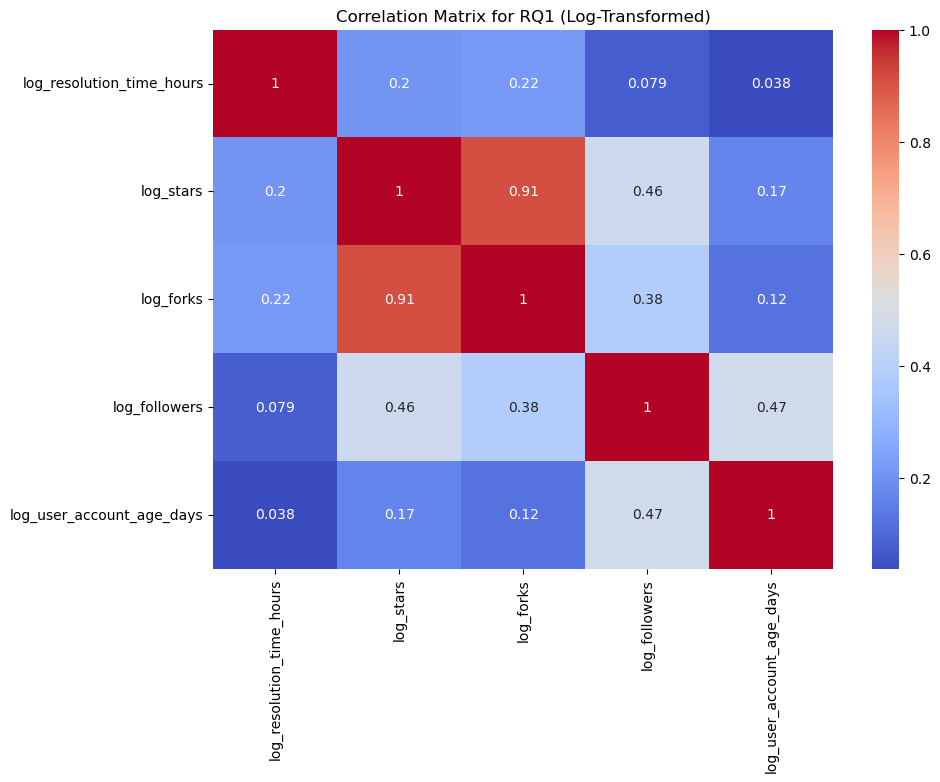

                                OLS Regression Results                               
Dep. Variable:     log_resolution_time_hours   R-squared:                       0.049
Model:                                   OLS   Adj. R-squared:                  0.049
Method:                        Least Squares   F-statistic:                 1.058e+04
Date:                       Thu, 04 Dec 2025   Prob (F-statistic):               0.00
Time:                               13:57:50   Log-Likelihood:            -1.1122e+06
No. Observations:                     817668   AIC:                         2.224e+06
Df Residuals:                         817663   BIC:                         2.225e+06
Df Model:                                  4                                         
Covariance Type:                   nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from textblob import TextBlob


# 1. Load Data
all_pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_pull_request.parquet")
all_repo_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_repository.parquet")
all_user_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_user.parquet")

# 2. Preprocess and Merge

# Convert timestamps
all_pr_df['created_at'] = pd.to_datetime(all_pr_df['created_at'])
all_pr_df['closed_at']  = pd.to_datetime(all_pr_df['closed_at'])
all_pr_df['merged_at']  = pd.to_datetime(all_pr_df['merged_at'])

all_user_df['created_at'] = pd.to_datetime(all_user_df['created_at'])

# Merge PR ↔ Repo
df = all_pr_df.merge(
    all_repo_df,
    left_on='repo_id',
    right_on='id',
    suffixes=('_pr', '_repo')
)

# Merge PR ↔ User
df = df.merge(
    all_user_df,
    left_on='user_id',
    right_on='id',
    suffixes=('', '_user')
)


# 3. Feature Engineering

# PR resolution time (in hours)
df['resolution_time_hours'] = (
    df['closed_at'] - df['created_at']
).dt.total_seconds() / 3600

# User account age at PR creation (days)
df['user_account_age_days'] = (
    df['created_at'] - df['created_at_user']
).dt.days

# Keep only closed PRs
rq1_data = df[df['state'] == 'closed'].copy()

# Drop rows where resolution time or age is missing
rq1_data = rq1_data.dropna(subset=[
    'resolution_time_hours',
    'stars',
    'forks',
    'followers',
    'user_account_age_days'
])

# 4. Log Transform to Handle Heavy Skew

for col in ['stars', 'forks', 'followers', 'user_account_age_days', 'resolution_time_hours']:
    rq1_data[f'log_{col}'] = np.log1p(rq1_data[col])


# 5. Correlation Matrix
corr_cols = [
    'log_resolution_time_hours',
    'log_stars',
    'log_forks',
    'log_followers',
    'log_user_account_age_days'
]

plt.figure(figsize=(10, 7))
sns.heatmap(rq1_data[corr_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix for RQ1 (Log-Transformed)")
plt.show()


# 6. OLS Regression
X = rq1_data[['log_stars', 'log_forks', 'log_followers', 'log_user_account_age_days']]
X = sm.add_constant(X)
y = rq1_data['log_resolution_time_hours']

model_rq1 = sm.OLS(y, X).fit()
print(model_rq1.summary())
